# 1. Downloading forcing data (WFDE5)

The first step in this notebook describes how the data can be downloaded. The raw data can be found in the data folder '/data/forcing_data/raw/WFDE5'. 

How to download the near-surface-meteorological-variables from the CDS API. Here version 2.1 is used.
Each variable is downloaded and saved as a zip file with the name of each variable. Each zip file is containing data for 1 year, so the data has to be saved as one netcdf file for each variable after the files are downloaded. The data will be downloaded into the present working directory.

In [1]:
# Import the necessary packages
import cdsapi
from zipfile import ZipFile
import matplotlib.pyplot as plt
from rasterio.plot import show
import glob
import xarray as xr
import os
import netCDF4 as nc
import numpy as np
from pyproj import Proj, Transformer, CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import math
import pandas as pd
import dask.array as da
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
import rasterio
from shapely.geometry import Point
import geopandas as gpd


Defining the region extent

In [2]:

### Hindu Kush-Himalayan region extent 
# Bajracharya, SR and Shrestha, B  (2011) 
# The status of glaciers in the Hindu Kush-Himalayan region. Kathmandu: ICIMOD

north = 39.31
west = 60.85
south = 15.95
east = 105.04

#### Bundhi Gandaki catchment ##### From QGIS

#south = 28.00
#north = 28.94
#west = 84.47
#east = 85.21

In [3]:
# Setting up a api client
c = cdsapi.Client()

Defining the variables

In [5]:
# Defining variables to include
cru_variables = ['near_surface_specific_humidity', 
            'near_surface_air_temperature', 
            'near_surface_specific_humidity', 
            'surface_air_pressure', 
           'surface_downwelling_shortwave_radiation',
           #'grid_point_altitude', 
           ]
cru_gpcc_variables = [ 
            'rainfall_flux', 
            'snowfall_flux', ]

# Wind speed data is downloaded for the years 1999 to 2016 only due to big data size
wind_speed = ['near_surface_wind_speed']

To download snowfall and rainfall flux, the cru_gpcc referance dataset was used and therefore the data download is  split up. These is also available as cru. Run the cells below and the data will be downloaded as tar zip files.

In [ ]:
for variable in cru_variables:
    c.retrieve(
        'derived-near-surface-meteorological-variables',
        {   'area': [north, west, south, east],
            'variable': f'{variable}',
            #cru_and_gpcc
            'reference_dataset': 'cru',
            'year': [
                '1990', '1991', '1992',
                '1993', '1994', '1995',
                '1996', '1997', '1998',
                '1999', '2000', '2001',
                '2002', '2003', '2004',
                '2005', '2006', '2007',
                '2008', '2009', '2010',
                '2011', '2012', '2013',
                '2014', '2015', '2016',
                '2017', '2018', '2019',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'version': '2.1',
            'format': 'tgz'
            
        },
        f'{variable}.tgz')

In [ ]:
for variable in cru_gpcc_variables:
    c.retrieve(
        'derived-near-surface-meteorological-variables',
        {   'area': [north, west, south, east],
            'variable': f'{variable}',
            #cru_and_gpcc
            'reference_dataset': 'cru',
            'year': [
                '1990', '1991', '1992',
                '1993', '1994', '1995',
                '1996', '1997', '1998',
                '1999', '2000', '2001',
                '2002', '2003', '2004',
                '2005', '2006', '2007',
                '2008', '2009', '2010',
                '2011', '2012', '2013',
                '2014', '2015', '2016',
                '2017', '2018', '2019',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'version': '2.1',
            'format': 'tgz'
            
        },
        f'{variable}.tgz')

In [ ]:
for variable in wind_speed:
    c.retrieve(
        'derived-near-surface-meteorological-variables',
        {   'area': [north, west, south, east],
            'variable': f'{variable}',
            #cru_and_gpcc
            'reference_dataset': 'cru',
            'year': [
                '1990', '1991', '1992',
                '1993', '1994', '1995',
                '1996', '1997', '1998',
                '1999', '2000', '2001',
                '2002', '2003', '2004',
                '2005', '2006', '2007',
                '2008', '2009', '2010',
                '2011', '2012', '2013',
                '2014', '2015', '2016',
                '2017', '2018', '2019',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'version': '2.1',
            'format': 'tgz'
            
        },
        f'{variable}.tgz')

Once the raw data is downloaded, the files are stored in the folder WFDE5_raw

# 2. Reading the raw data

In [3]:
# Defining where to find the raw data
wfde5_dir = 'raw/WFDE5'

In [4]:
tair_fn = wfde5_dir + '/tair/*.nc' # Near surface air temperature
psurf_fn = wfde5_dir + '/psurf/*.nc' # Near surface air pressure
qair_fn = wfde5_dir + '/qair/*.nc' # Near surface specific humidity
rainf_fn = wfde5_dir + '/rainf/*.nc' # Rainfall flux
snowf_fn = wfde5_dir + '/snowf/*.nc' # Snowfall flux
swdown_fn = wfde5_dir + '/swdown/*.nc' # Surface downwelling shortwave radiation
wind_fn = wfde5_dir + '/wind/*.nc' # Near surface wind speed
cell_data_fn = 'raw/cell_data/cell_data.nc' # Cell data

In [8]:
# Reading the data using xarray

tair_ds = xr.open_mfdataset(tair_fn)
psurf_ds = xr.open_mfdataset(psurf_fn)
qair_ds = xr.open_mfdataset(qair_fn)
rainf_ds = xr.open_mfdataset(rainf_fn)
snowf_ds = xr.open_mfdataset(snowf_fn)
swdown_ds = xr.open_mfdataset(swdown_fn)
wind_ds = xr.open_mfdataset(wind_fn)
cell_data_ds = xr.open_mfdataset(cell_data_fn)

OSError: no files to open

In [43]:
wind_ds

<xarray.Dataset>
Dimensions:  (time: 157800, lon: 88, lat: 47)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 ... 2016-12-31T23:00:00
  * lon      (lon) float64 61.25 61.75 62.25 62.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 16.25 16.75 17.25 17.75 ... 37.75 38.25 38.75 39.25
Data variables:
    Wind     (time, lat, lon) float32 dask.array<chunksize=(744, 47, 88), meta=np.ndarray>
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
    reference:    Cucchi et al., 2020, Earth Syst. Sci. Data, 12(3), 2097–212...
    licence:      The dataset is distributed under the Licence to Use Coperni...

In [23]:
# Example of temperature raw dataset
tair_ds

<xarray.Dataset>
Dimensions:  (time: 262968, lon: 88, lat: 47)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
  * lon      (lon) float64 61.25 61.75 62.25 62.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 16.25 16.75 17.25 17.75 ... 37.75 38.25 38.75 39.25
Data variables:
    Tair     (time, lat, lon) float32 dask.array<chunksize=(744, 47, 88), meta=np.ndarray>
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
    reference:    Cucchi et al., 2020, Earth Syst. Sci. Data, 12(3), 2097–212...
    licence:      The dataset is distributed under the Licence to Use Coperni...

# 3. Checking for missing values

Missing values appear as yellow in the figures

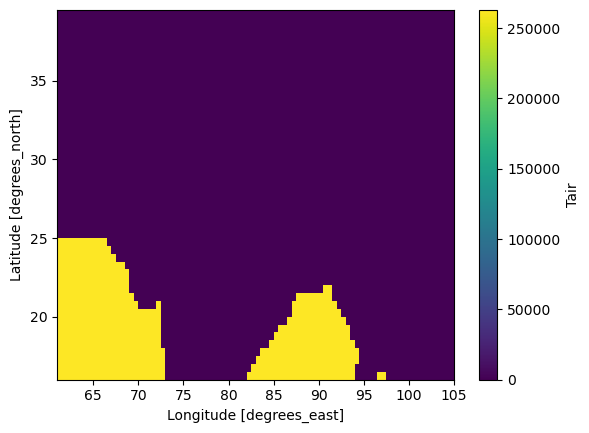

In [16]:
# Testing for missing values
tair_ds.Tair.isnull().sum(dim = 'time').plot()

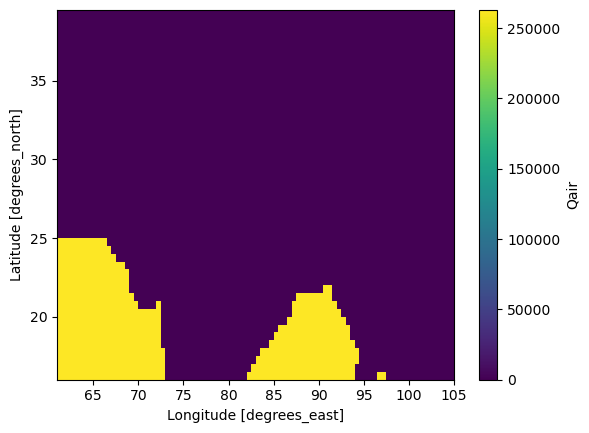

In [24]:
qair_ds.Qair.isnull().sum(dim = 'time').plot()

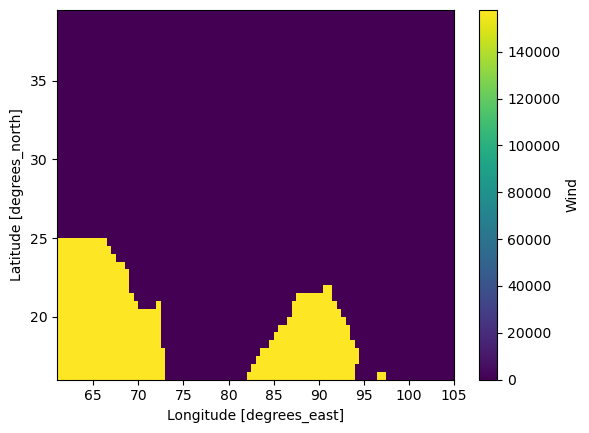

In [25]:
wind_ds.Wind.isnull().sum(dim = 'time').plot()

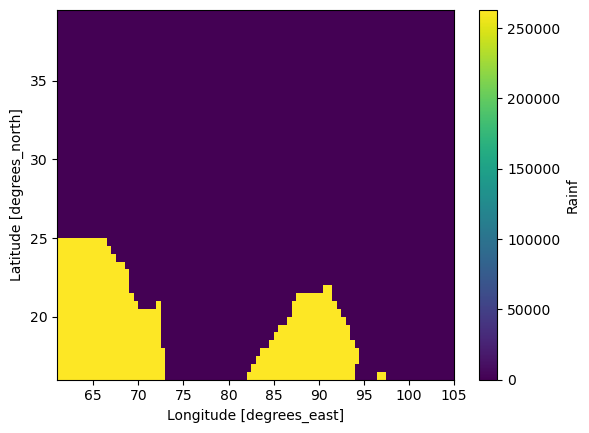

In [26]:
rainf_ds.Rainf.isnull().sum(dim = 'time').plot()

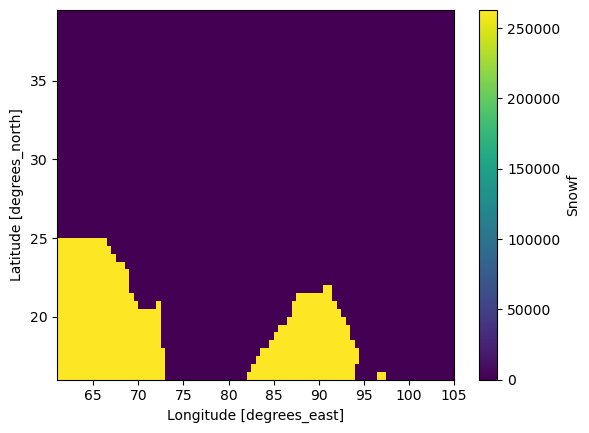

In [27]:
snowf_ds.Snowf.isnull().sum(dim = 'time').plot()

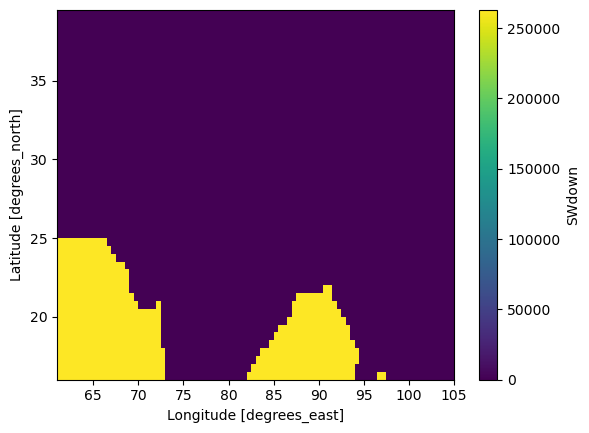

In [28]:
swdown_ds.SWdown.isnull().sum(dim = 'time').plot()

The raw data does not seem to have any missing values

# 4. Extracting raw data for Budhi Gandaki only

Making sure all the Budhi Gandaki cells are covered, the cell data coordinates are extracted

Budhi Gandaki has catchment id 10, so we select only these cells and drop the rest

In [153]:
cell_data_ds = cell_data_ds.where(cell_data_ds.catchment_id == 10, drop = True)

In [63]:
# Budhi Gandaki cells
cell_data_ds

<xarray.Dataset>
Dimensions:             (cell: 1077, crs_dim: 0)
Coordinates:
    x                   (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    y                   (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    z                   (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
Dimensions without coordinates: cell, crs_dim
Data variables:
    forest-fraction     (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    reservoir-fraction  (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    lake-fraction       (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    glacier-fraction    (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    area                (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    catchment_id        (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    crs                 (crs_dim, cell) float64 dask.array<chunksize=(0, 1077), meta=np.ndarray>
    aspect              (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>
    slope               (cell) float64 dask.array<chunksize=(1077,), meta=np.ndarray>

In [154]:
# Extracting the coordinates of the cells
x = cell_data_ds.x.values
y = cell_data_ds.y.values

We now have the shyft cell coordinates for the simulation, but we need to convert these to lat and lon to select the raw data for the Narayni catchment

In [155]:
# Get lat and lon to extract from WFDE5

## Making a pyproj object for UTM Zone 45N

crs_32645 = CRS.from_epsg(32645) # CRS from cell_data file
crs_4326 = CRS.from_epsg(4326) # Lat-lon


## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_32645, crs_4326, always_xy = True)

lon, lat = transformer.transform(x, y)

lon.sort()
lat.sort()

In [156]:
# Printing of the min and max coordinates
# Min and max cooridnates to extract from

min_lon = lon.min()
print(f'Min lon cell data: {min_lon}')
min_lat = lat.min()
print(f'Min lat cell data: {min_lat}')
max_lon = lon.max()
print(f'Max lon cell data: {max_lon}')
max_lat = lat.max()
print(f'Max lat cell data: {max_lat}')

Min lon cell data: 84.45936866878183
Min lat cell data: 28.0295407129634
Max lon cell data: 85.18843138140717
Max lat cell data: 28.92290313499464


In [157]:
# Printing the coordinates of raw data
print('Lon: ', psurf_ds.lon.values)
print('Lat: ', psurf_ds.lat.values)

Lon:  [ 61.25  61.75  62.25  62.75  63.25  63.75  64.25  64.75  65.25  65.75
  66.25  66.75  67.25  67.75  68.25  68.75  69.25  69.75  70.25  70.75
  71.25  71.75  72.25  72.75  73.25  73.75  74.25  74.75  75.25  75.75
  76.25  76.75  77.25  77.75  78.25  78.75  79.25  79.75  80.25  80.75
  81.25  81.75  82.25  82.75  83.25  83.75  84.25  84.75  85.25  85.75
  86.25  86.75  87.25  87.75  88.25  88.75  89.25  89.75  90.25  90.75
  91.25  91.75  92.25  92.75  93.25  93.75  94.25  94.75  95.25  95.75
  96.25  96.75  97.25  97.75  98.25  98.75  99.25  99.75 100.25 100.75
 101.25 101.75 102.25 102.75 103.25 103.75 104.25 104.75]
Lat:  [16.25 16.75 17.25 17.75 18.25 18.75 19.25 19.75 20.25 20.75 21.25 21.75
 22.25 22.75 23.25 23.75 24.25 24.75 25.25 25.75 26.25 26.75 27.25 27.75
 28.25 28.75 29.25 29.75 30.25 30.75 31.25 31.75 32.25 32.75 33.25 33.75
 34.25 34.75 35.25 35.75 36.25 36.75 37.25 37.75 38.25 38.75 39.25]


We can see that the coordinates from the raw data have increments of 0.5 degrees. We must make sure that the min and max values we pick are below the min and max values from the cell data. We should also make sure that the lon and lat values have the same dimension. The coordinates represent the mid point value of each forcing cell.

To get the min and max values that cover the whole catchment and that have the same dimensions, the shapefile in the raw cell data folder was used in QGIS in addition to the WFDE5 data. 

In [158]:
# This gives 
min_lat = 27.75
max_lat = 29.25
min_lon = 84.25
max_lon = 85.75

In [159]:
# Get only data for the extended Budhi Gandaki area
psurf_slice = psurf_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
wind_slice = wind_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
tair_slice = tair_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
rainf_slice = rainf_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
snowf_slice = snowf_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
qair_slice = qair_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
swdown_slice = swdown_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))

We now have selected the raw data for Budhi Gandaki, but since Shyft needs precipitation, temperature, shortwave radiation, wind speed and relative humidity, the data has to be converted

# 5. Converting raw data to Shyft variables

In [160]:
#Checking the units of the variables
print(tair_ds.Tair.attrs)
print(psurf_ds.PSurf.attrs)
print(qair_ds.Qair.attrs)
print(rainf_ds.Rainf.attrs)
print(snowf_ds.Snowf.attrs)
print(swdown_ds.SWdown.attrs)
print(wind_ds.Wind.attrs)

{'long_name': 'Near-Surface Air Temperature', 'standard_name': 'air_temperature', 'units': 'K'}
{'units': 'Pa', 'long_name': 'Surface Air Pressure', 'standard_name': 'surface_air_pressure'}
{'units': 'kg kg-1', 'long_name': 'Near-Surface Specific Humidity', 'standard_name': 'specific_humidity'}
{'units': 'kg m-2 s-1', 'long_name': 'Rainfall Flux', 'standard_name': 'rainfall_flux'}
{'units': 'kg m-2 s-1', 'long_name': 'Snowfall Flux', 'standard_name': 'snowfall_flux'}
{'long_name': 'Surface Downwelling Shortwave Radiation', 'standard_name': 'surface_downwelling_shortwave_flux_in_air', 'units': 'W m-2'}
{'units': 'm s-1', 'long_name': 'Near-Surface Wind Speed', 'standard_name': 'wind_speed'}


We can see that:
* temperature has unit kelvin
* wind speed has unit m/s
* shortwave radiation has unit W/m^2
* surface pressure has unit Pa
* Specific humidity is unitless
* snowfall and rainfall flux have units kg m-2 s-1.

Shyft needs temperature in celsius degrees, wind speed in m/s, precipitation in mm/hr, surface pressure in hPa, radiation in W/m^2 and relative humidity is unitless. Therefore we need to convert temperature to celsius degrees, snowfall and rainfall flux to precipitation in mm/hr, surface pressure to hPa, and use a Python package to find the relative humidity

The temperature, precipitation and pressure conversions are relatively straight forward

In [8]:
# For HMA (Himalayan region) the data is first sampled to daily 

tair_ds = tair_ds.resample(time = '1D').mean()
rainf_ds = rainf_ds.resample(time = '1D').mean()
snowf_ds = snowf_ds.resample(time = '1D').mean()
qair_ds = qair_ds.resample(time = '1D').mean()
psurf_ds = psurf_ds.resample(time = '1D').mean()
swdown_ds = swdown_ds.resample(time = '1D').mean()
wind_ds = wind_ds.resample(time = '1D').mean()

T_degc_hma = tair_ds.Tair - 273.15 # Convert to degC
tair_ds = tair_ds.assign(Tair_degc= T_degc_hma)

Precip_hma = rainf_ds.Rainf * 3600 + snowf_ds.Snowf * 3600 # Convert to mm/h (kg/m2/s * 3600 s = mm/h)
rainf_ds = rainf_ds.assign(Precip = Precip_hma)

PSurf_hpa_hma = psurf_ds.PSurf * 0.01 # Convert to hPa
psurf_ds = psurf_ds.assign(PSurf_hpa = PSurf_hpa_hma)



# For Budhi Gandaki
## Temperature
T_degc = tair_slice.Tair - 273.15 # Convert to degC
tair_slice = tair_slice.assign(Tair_degc= T_degc)

# Precipitation
Precip = rainf_slice.Rainf * 3600 + snowf_slice.Snowf * 3600 # Convert to mm/h (kg/m2/s * 3600 s = mm/h)
rainf_slice = rainf_slice.assign(Precip = Precip)

# Pressure
PSurf_hpa = psurf_slice.PSurf * 0.01 # Convert to hPa
psurf_slice = psurf_slice.assign(PSurf_hpa = PSurf_hpa)

NameError: name 'tair_slice' is not defined

The relative humidity can be calculated using the 'relative_humidity_from_specific_humidity' function from [Metpy](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.relative_humidity_from_specific_humidity.html). The dataset is quite large, so in order to calculate the relative humidity using the Metpy function, the dataset is split in half and each half is calculated separately and then these to are merged again>

In [164]:
# Calulating relative humidity
rel_hum = relative_humidity_from_specific_humidity(psurf_slice.PSurf_hpa.values * units.hPa, tair_slice.Tair_degc.values * units.degC, qair_slice.Qair.values).to('percent').magnitude

In [11]:
# Relative humidity for HMA
rel_hum_hma = relative_humidity_from_specific_humidity(psurf_ds.PSurf_hpa.values * units.hPa, tair_ds.Tair_degc.values * units.degC, qair_ds.Qair.values).to('percent').magnitude

In [13]:
rel_hum = rel_hum * 0.01 # Convert to fraction
rel_hum_hma = rel_hum_hma * 0.01 # Convert to fraction

In [19]:
# Relative humidity
qair_ds = qair_ds.assign(relative_humidity = (['time', 'lat', 'lon'], rel_hum_hma))
qair_slice = qair_slice.assign(relative_humidity = (['time', 'lon', 'lat'], rel_hum))

# 6. Getting elevation

In [168]:
# Need to now get elevation from a merged DEM from Central Himalaya 
# obtained by the USGS Earth Explorer and using QGIS to merge the tiles

# First we need to stack the data into stations (cells in Shyft)

psurf_slice_stacked = psurf_slice.stack(station = ['lon', 'lat'])

In [170]:
# Making a list with a tuple of all (lon, lat) points

stations = psurf_slice_stacked.station.values

In [173]:
# The cell in Shyft have these coordinates for the forcing data
stations

array([(84.25, 27.75), (84.25, 28.25), (84.25, 28.75), (84.25, 29.25),
       (84.75, 27.75), (84.75, 28.25), (84.75, 28.75), (84.75, 29.25),
       (85.25, 27.75), (85.25, 28.25), (85.25, 28.75), (85.25, 29.25),
       (85.75, 27.75), (85.75, 28.25), (85.75, 28.75), (85.75, 29.25)],
      dtype=object)

In [174]:
# Now we need to convert the list of tuples to a list of Point objects

points = []
for i in range(len(stations)):
    points.append(Point((stations[i][0], stations[i][1])))

In [176]:
# Make a GeoPandas dataframe with the cells

gdf = gpd.GeoDataFrame(np.arange(len(points)), geometry = points, crs = 4326)
gdf

,0,geometry
0,0,POINT (84.25000 27.75000)
1,1,POINT (84.25000 28.25000)
2,2,POINT (84.25000 28.75000)
3,3,POINT (84.25000 29.25000)
4,4,POINT (84.75000 27.75000)
5,5,POINT (84.75000 28.25000)
6,6,POINT (84.75000 28.75000)
7,7,POINT (84.75000 29.25000)
8,8,POINT (85.25000 27.75000)
9,9,POINT (85.25000 28.25000)


In [177]:
# Make a list of all the points (lon, lat)
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

In [2]:
# To get altitude DEM tiles from USGS are merged into one DEM using QGIS and CRS: 4326

## Opening this merged DEM

dem_dataset = rasterio.open('DEM/merged_DEM_central_himalaya.tif')

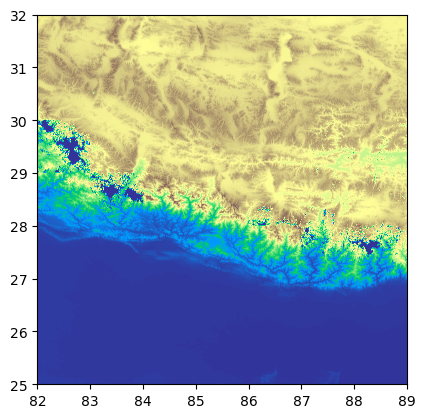

<AxesSubplot:>

In [3]:
# Plotting the DEM
show(dem_dataset, cmap = 'terrain')


In [186]:
# Sample the coordinate points in coord_list in the DEM file
gdf['value'] = [x for x in dem_dataset.sample(coord_list)]

In [187]:
# Getting a list of all z values
z = []
for i in gdf['value'].values:
    z.append(i[0].astype('float64'))

In [205]:
# Checking if there any zero or nan values for z
z

[689.0,
 1457.0,
 4855.0,
 5159.0,
 1258.0,
 2163.0,
 4381.0,
 4532.0,
 2083.0,
 4063.0,
 4773.0,
 4598.0,
 1545.0,
 6612.0,
 4667.0,
 4549.0]

# 7 Convert coordinates to UTM coordinates

In [189]:
# Now we stack also the forcing datasets to get stations

tair_slice_stacked = tair_slice.stack(station = ['lon', 'lat'])
wind_slice_stacked = wind_slice.stack(station = ['lon', 'lat'])
rainf_slice_stacked = rainf_slice.stack(station = ['lon', 'lat'])
qair_slice_stacked = qair_slice.stack(station = ['lon', 'lat'])
swdown_slice_stacked = swdown_slice.stack(station = ['lon', 'lat'])

In [190]:
## Making a pyproj object for UTM Zone 45N

lon_slice_stacked_psurf = psurf_slice_stacked.lon.values
lat_slice_stacked_psurf = psurf_slice_stacked.lat.values

crs_4326 = CRS.from_epsg(4326) # Lat-lon
crs_32645 = CRS.from_epsg(32645) # CRS 

## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_4326, crs_32645, always_xy = True)

x, y = transformer.transform(lon_slice_stacked_psurf, lat_slice_stacked_psurf)

# 8 Create the netcdf files ready for Shyft

In [191]:
ds_temperature = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(tair_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        temperature = (['time', 'station'], tair_slice_stacked.Tair_degc.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], tair_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [192]:
ds_precipitation = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(rainf_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        precipitation = (['time', 'station'], rainf_slice_stacked.Precip.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], rainf_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [193]:
ds_wind = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(wind_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        wind_speed = (['time', 'station'], wind_slice_stacked.Wind.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], wind_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [194]:
ds_rel_hum = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(qair_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        relative_humidity = (['time', 'station'], qair_slice_stacked.relative_humidity.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], qair_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [195]:
ds_radiation = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(swdown_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        global_radiation = (['time', 'station'], swdown_slice_stacked.SWdown.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], swdown_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

We now need to add the attributes that describe the datasets

In [202]:
# WIND

ds_wind.x.attrs['axis'] = 'X'
ds_wind.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_wind.x.attrs['units'] = 'm'

ds_wind.y.attrs['axis'] = 'Y'
ds_wind.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_wind.y.attrs['units'] = 'm'

ds_wind.z.attrs['units'] = 'm'
ds_wind.z.attrs['standard_name'] = 'height'
ds_wind.z.attrs['axis'] = 'Z'
ds_wind.z.attrs['long_name'] = 'height above mean sea level'

ds_wind.series_name.attrs['cf_role'] = 'timeseries_id'

ds_wind.wind_speed.attrs['units'] = 'm s-1'
ds_wind.wind_speed.attrs['grid_mapping'] = 'crs'

ds_wind.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_wind.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_wind.crs.attrs['epsg_code'] = 'EPSG:32645'


# TEMPERATURE

ds_temperature.x.attrs['axis'] = 'X'
ds_temperature.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_temperature.x.attrs['units'] = 'm'

ds_temperature.y.attrs['axis'] = 'Y'
ds_temperature.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_temperature.y.attrs['units'] = 'm'

ds_temperature.z.attrs['units'] = 'm'
ds_temperature.z.attrs['standard_name'] = 'height'
ds_temperature.z.attrs['axis'] = 'Z'
ds_temperature.z.attrs['long_name'] = 'height above mean sea level'

ds_temperature.series_name.attrs['cf_role'] = 'timeseries_id'

ds_temperature.temperature.attrs['units'] = 'degC'
ds_temperature.temperature.attrs['grid_mapping'] = 'crs'

ds_temperature.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_temperature.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_temperature.crs.attrs['epsg_code'] = 'EPSG:32645'

# RADIATION

ds_radiation.x.attrs['axis'] = 'X'
ds_radiation.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_radiation.x.attrs['units'] = 'm'

ds_radiation.y.attrs['axis'] = 'Y'
ds_radiation.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_radiation.y.attrs['units'] = 'm'

ds_radiation.z.attrs['units'] = 'm'
ds_radiation.z.attrs['standard_name'] = 'height'
ds_radiation.z.attrs['axis'] = 'Z'
ds_radiation.z.attrs['long_name'] = 'height above mean sea level'

ds_radiation.series_name.attrs['cf_role'] = 'timeseries_id'

ds_radiation.global_radiation.attrs['units'] = 'W m-2'
ds_radiation.global_radiation.attrs['grid_mapping'] = 'crs'

ds_radiation.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_radiation.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_radiation.crs.attrs['epsg_code'] = 'EPSG:32645'

# RELATIVE HUMIDITY

ds_rel_hum.x.attrs['axis'] = 'X'
ds_rel_hum.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_rel_hum.x.attrs['units'] = 'm'

ds_rel_hum.y.attrs['axis'] = 'Y'
ds_rel_hum.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_rel_hum.y.attrs['units'] = 'm'

ds_rel_hum.z.attrs['units'] = 'm'
ds_rel_hum.z.attrs['standard_name'] = 'height'
ds_rel_hum.z.attrs['axis'] = 'Z'
ds_rel_hum.z.attrs['long_name'] = 'height above mean sea level'

ds_rel_hum.series_name.attrs['cf_role'] = 'timeseries_id'

ds_rel_hum.relative_humidity.attrs['units'] = '-'
ds_rel_hum.relative_humidity.attrs['grid_mapping'] = 'crs'

ds_rel_hum.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_rel_hum.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_rel_hum.crs.attrs['epsg_code'] = 'EPSG:32645'

# PRECIPITATION

ds_precipitation.x.attrs['axis'] = 'X'
ds_precipitation.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_precipitation.x.attrs['units'] = 'm'

ds_precipitation.y.attrs['axis'] = 'Y'
ds_precipitation.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_precipitation.y.attrs['units'] = 'm'

ds_precipitation.z.attrs['units'] = 'm'
ds_precipitation.z.attrs['standard_name'] = 'height'
ds_precipitation.z.attrs['axis'] = 'Z'
ds_precipitation.z.attrs['long_name'] = 'height above mean sea level'

ds_precipitation.series_name.attrs['cf_role'] = 'timeseries_id'

ds_precipitation.precipitation.attrs['units'] = 'mm h-1'
ds_precipitation.precipitation.attrs['grid_mapping'] = 'crs'

ds_precipitation.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_precipitation.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_precipitation.crs.attrs['epsg_code'] = 'EPSG:32645'



In [206]:
# Checking the datasets if they are correctly set up
ds_temperature

<xarray.Dataset>
Dimensions:      (station: 16, time: 262968)
Coordinates:
  * time         (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x            (station) float64 2.289e+05 2.302e+05 ... 3.78e+05 3.785e+05
    y            (station) float64 3.073e+06 3.128e+06 ... 3.181e+06 3.236e+06
    z            (station) float64 689.0 1.457e+03 ... 4.667e+03 4.549e+03
Dimensions without coordinates: station
Data variables:
    series_name  (station) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    crs          int32 -2147483647
    temperature  (time, station) float64 5.865 -3.942 -25.69 ... -21.96 -19.98

In [197]:
ds_precipitation

<xarray.Dataset>
Dimensions:        (station: 16, time: 262968)
Coordinates:
  * time           (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x              (station) float64 2.289e+05 2.302e+05 ... 3.78e+05 3.785e+05
    y              (station) float64 3.073e+06 3.128e+06 ... 3.181e+06 3.236e+06
    z              (station) float64 689.0 1.457e+03 ... 4.667e+03 4.549e+03
Dimensions without coordinates: station
Data variables:
    series_name    (station) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    crs            int32 -2147483647
    precipitation  (time, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [198]:
ds_radiation

<xarray.Dataset>
Dimensions:           (station: 16, time: 262968)
Coordinates:
  * time              (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x                 (station) float64 2.289e+05 2.302e+05 ... 3.785e+05
    y                 (station) float64 3.073e+06 3.128e+06 ... 3.236e+06
    z                 (station) float64 689.0 1.457e+03 ... 4.667e+03 4.549e+03
Dimensions without coordinates: station
Data variables:
    series_name       (station) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    crs               int32 -2147483647
    global_radiation  (time, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [199]:
ds_wind

<xarray.Dataset>
Dimensions:      (station: 16, time: 157800)
Coordinates:
  * time         (time) datetime64[ns] 1999-01-01 ... 2016-12-31T23:00:00
    x            (station) float64 2.289e+05 2.302e+05 ... 3.78e+05 3.785e+05
    y            (station) float64 3.073e+06 3.128e+06 ... 3.181e+06 3.236e+06
    z            (station) float64 689.0 1.457e+03 ... 4.667e+03 4.549e+03
Dimensions without coordinates: station
Data variables:
    series_name  (station) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    crs          int32 -2147483647
    wind_speed   (time, station) float64 1.035 1.067 1.297 ... 0.9855 0.4566

In [208]:
# Checking values of datasets

## Checking for nans
t_bool = np.sum(ds_temperature.temperature.isnull().values)
r_bool = np.sum(ds_radiation.global_radiation.isnull().values)
rh_bool = np.sum(ds_rel_hum.relative_humidity.isnull().values)
w_bool = np.sum(ds_wind.wind_speed.isnull().values)
p_bool = np.sum(ds_precipitation.precipitation.isnull().values)
print(t_bool)
print(r_bool)
print(rh_bool)
print(w_bool)
print(p_bool)

0
0
0
0
0


In [214]:
## Specify path where files are saved
home_dir = os.getenv('HOME')
output_folder = home_dir + '/Documents/MST Himalaya/MST-Himalaya/data/forcing_data/prepared'
output_wind = output_folder + '/wind_speed.nc'
output_rel_hum = output_folder + '/relative_humidity.nc'
output_temp = output_folder + '/temperature.nc'
output_radiation = output_folder + '/radiation.nc'
output_precipitation = output_folder + '/precipitation.nc'

In [215]:
## Save netcdf files
ds_wind.to_netcdf(path = output_wind, format = 'NETCDF4')
ds_rel_hum.to_netcdf(path = output_rel_hum, format = 'NETCDF4')
ds_temperature.to_netcdf(path = output_temp, format = 'NETCDF4')
ds_radiation.to_netcdf(path = output_radiation, format = 'NETCDF4')
ds_precipitation.to_netcdf(path = output_precipitation, format = 'NETCDF4')

In [216]:
# Testing if the files can be opened
xr.open_mfdataset(output_wind)

<xarray.Dataset>
Dimensions:      (station: 16, time: 157800)
Coordinates:
  * time         (time) datetime64[ns] 1999-01-01 ... 2016-12-31T23:00:00
    x            (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    y            (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    z            (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name  (station) int64 dask.array<chunksize=(16,), meta=np.ndarray>
    crs          int32 ...
    wind_speed   (time, station) float64 dask.array<chunksize=(157800, 16), meta=np.ndarray>

In [217]:
xr.open_mfdataset(output_rel_hum)

<xarray.Dataset>
Dimensions:            (station: 16, time: 262968)
Coordinates:
  * time               (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x                  (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    y                  (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    z                  (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name        (station) int64 dask.array<chunksize=(16,), meta=np.ndarray>
    crs                int32 ...
    relative_humidity  (time, station) float64 dask.array<chunksize=(262968, 16), meta=np.ndarray>

In [218]:
xr.open_mfdataset(output_temp)

<xarray.Dataset>
Dimensions:      (station: 16, time: 262968)
Coordinates:
  * time         (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x            (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    y            (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    z            (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name  (station) int64 dask.array<chunksize=(16,), meta=np.ndarray>
    crs          int32 ...
    temperature  (time, station) float64 dask.array<chunksize=(262968, 16), meta=np.ndarray>

In [220]:
xr.open_mfdataset(output_radiation)

<xarray.Dataset>
Dimensions:           (station: 16, time: 262968)
Coordinates:
  * time              (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x                 (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    y                 (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    z                 (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name       (station) int64 dask.array<chunksize=(16,), meta=np.ndarray>
    crs               int32 ...
    global_radiation  (time, station) float64 dask.array<chunksize=(262968, 16), meta=np.ndarray>

In [221]:
xr.open_mfdataset(output_precipitation)

<xarray.Dataset>
Dimensions:        (station: 16, time: 262968)
Coordinates:
  * time           (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x              (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    y              (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    z              (station) float64 dask.array<chunksize=(16,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name    (station) int64 dask.array<chunksize=(16,), meta=np.ndarray>
    crs            int32 ...
    precipitation  (time, station) float64 dask.array<chunksize=(262968, 16), meta=np.ndarray>

# 9. Creating the dataset for HMA for analysis

In [22]:
ds_temperature_hma = xr.Dataset(
    data_vars = dict(
        temperature = (['time', 'lat', 'lon'], tair_ds.Tair_degc.values),
    ),
    coords = dict(
        time = (['time'], tair_ds.time.values),
        lon = (['lon'], tair_ds.lon.values),
        lat = (['lat'], tair_ds.lat.values),
    )  
)

In [26]:
ds_precip_hma = xr.Dataset(
    data_vars = dict(
        precipitation = (['time', 'lat', 'lon'], rainf_ds.Precip.values),
    ),
    coords = dict(
        time = (['time'], rainf_ds.time.values),
        lon = (['lon'], rainf_ds.lon.values),
        lat = (['lat'], rainf_ds.lat.values),
    )  
)

In [30]:
ds_rel_hum_hma = xr.Dataset(
    data_vars = dict(
        relative_humidity = (['time', 'lat', 'lon'], qair_ds.relative_humidity.values),
    ),
    coords = dict(
        time = (['time'], qair_ds.time.values),
        lon = (['lon'], qair_ds.lon.values),
        lat = (['lat'], qair_ds.lat.values),
    )  
)

In [36]:
ds_wind_hma = xr.Dataset(
    data_vars = dict(
        wind = (['time', 'lat', 'lon'], wind_ds.Wind.values),
    ),
    coords = dict(
        time = (['time'], wind_ds.time.values),
        lon = (['lon'], wind_ds.lon.values),
        lat = (['lat'], wind_ds.lat.values),
    )  
)

In [37]:
ds_radiation_hma = xr.Dataset(
    data_vars = dict(
        radiation = (['time', 'lat', 'lon'], swdown_ds.SWdown.values),
    ),
    coords = dict(
        time = (['time'], swdown_ds.time.values),
        lon = (['lon'], swdown_ds.lon.values),
        lat = (['lat'], swdown_ds.lat.values),
    )  
)

In [38]:
## Specify path where files are saved
home_dir = os.getenv('HOME')
output_folder = home_dir + '/Documents/MST Himalaya/MST-Himalaya/data/HMA'
output_wind = output_folder + '/wind_speed.nc'
output_rel_hum = output_folder + '/relative_humidity.nc'
output_temp = output_folder + '/temperature.nc'
output_radiation = output_folder + '/radiation.nc'
output_precipitation = output_folder + '/precipitation.nc'

In [40]:
## Save netcdf files
ds_wind_hma.to_netcdf(path = output_wind, format = 'NETCDF4')
ds_rel_hum_hma.to_netcdf(path = output_rel_hum, format = 'NETCDF4')
ds_temperature_hma.to_netcdf(path = output_temp, format = 'NETCDF4')
ds_radiation_hma.to_netcdf(path = output_radiation, format = 'NETCDF4')
ds_precip_hma.to_netcdf(path = output_precipitation, format = 'NETCDF4')